In [2]:
import os
import torch
from PIL import Image
import torch.nn as nn
import numpy as np
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import Dataset
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.is_available()

False

In [5]:
def psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PSNR = 10 * np.log10(1 / (mse))
    return PSNR

In [6]:
def unnormalized_show(img):
    img = img * 0.5 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    return np.transpose(npimg, (2, 3, 1, 0))


In [7]:
def findlabel(featurepath,labelimgs):
    count = 0;
    index = count;
    for k in labelimgs:
        if k[-8:-4] == featurepath[-8:-4]:
            index = count
        count = count+1
    return index

In [8]:
class compset(Dataset):
    def __init__(self,featroot,labelroot):
        featimgs = os.listdir(featroot)
        self.featimgs=[os.path.join(featroot,k) for k in featimgs]
        self.featimgs.sort(key=lambda x:int(x[-8:-4]))
        #self.featimgs.sort(key=lambda x:float(x[-12:-8]))
        labelimgs = os.listdir(labelroot)
        self.labelimgs=[os.path.join(labelroot,k) for k in labelimgs]
        self.labelimgs.sort(key=lambda x:int(x[-8:-4]))
        self.transforms = transform
        
    def __getitem__(self, index):
        feature_img_path = self.featimgs[index]
        feature_img = Image.open(feature_img_path)
        if self.transforms:
            feature = self.transforms(feature_img)
        else:
            feature = np.asarray(feature_img)
            feature = torch.from_numpy(feature)
        
        labelindex = findlabel(feature_img_path,self.labelimgs);
        label_img_path = self.labelimgs[labelindex]
        label_img = Image.open(label_img_path)
        if self.transforms:
            label = self.transforms(label_img)
        else:
            label = np.asarray(label_img)
            label = torch.from_numpy(label)
        data = (feature,label)
        return data
    
    def __len__(self):
        return len(self.featimgs)

In [9]:
coastguard = 'coastguard20_40_RGB/'
akiyo = 'akiyo20_40_RGB/'
news = 'news20_40_RGB/'
silent = 'silent20_40_RGB/'
featpath = './train_feature/'
labelpath = './train_label/'


In [10]:
Q = 'Q0.15/'
train1 = compset(os.path.join(featpath ,coastguard,Q),os.path.join(labelpath,coastguard))
train2 = compset(os.path.join(featpath ,akiyo,Q),os.path.join(labelpath,akiyo))
train3 = compset(os.path.join(featpath ,news,Q),os.path.join(labelpath,news))
train4 = compset(os.path.join(featpath ,silent,Q),os.path.join(labelpath,silent))
train = torch.utils.data.ConcatDataset([train1,train2,train3,train4])
data_train = torch.utils.data.DataLoader(dataset=train, batch_size = 5, shuffle = True)

In [11]:
class ARCNN(nn.Module):

    def __init__(self):
        """
        Class constructor which preinitializes NN layers with trainable
        parameters.
        """
        super(ARCNN, self).__init__()
        # 3 input image channel, 64 output channels, 9x9 square convolution
        # conv kernel
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, bias=None, stride=1, padding=4)
        nn.init.normal_(self.conv1.weight,mean=0.0,std=0.001)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=7, bias=None, stride=1, padding=3)
        nn.init.normal_(self.conv2.weight,mean=0.0,std=0.001)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=1, bias=None, stride=1, padding=0)
        nn.init.normal_(self.conv3.weight,mean=0.0,std=0.001)
        self.conv4 = nn.Conv2d(16, 3, kernel_size=5, bias=None, stride=1, padding=2)
        nn.init.normal_(self.conv4.weight,mean=0.0,std=0.001)



    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x 

In [12]:
model = ARCNN().cpu()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
cost = nn.MSELoss()
n_epochs = 30

In [13]:
model.load_state_dict(torch.load("./model_parameter.pkl",map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
# for epoch in range(n_epochs):
#         running_loss = 0.0
#         running_correct = 0
#         print("Epoch {}/{}".format(epoch, n_epochs))
#         print("-"*10)
#         for data in data_train:
#             X_train, y_train = data
#             X_train, y_train = Variable(X_train).cuda(), Variable(y_train).cuda()
#             outputs = model(X_train)
#             loss = cost(outputs, y_train)
#             optimizer.zero_grad()

#             loss.backward()
#             optimizer.step()
#             running_loss += loss.data
#             #running_correct += torch.sum(pred == y_train.data)

#         print("Loss is:{:.8f}".format(running_loss/len(data_train)))
                                                                                          

In [15]:
#torch.save(model.state_dict(), "./model_parameter.pkl")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0017, grad_fn=<MseLossBackward>)
33.27948670049424
33.62413866175969


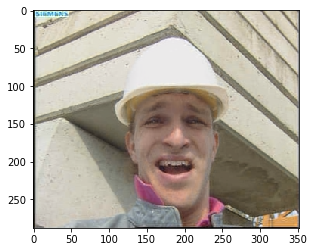

In [63]:
testfpath = os.path.join('./train_feature/foreman20_40_RGB/','Q1.35/')
testlpath = os.path.join('./train_label/foreman20_40_RGB/')
#testfpath = './IMG/'
#testlpath = './IMG/'
test = compset(testfpath,testlpath)
data_test = torch.utils.data.DataLoader(dataset=test, batch_size = 1, shuffle = True)
for X,Y in data_test:
    X = Variable(X).cpu()
    Y_rec = model(X)
    print(cost(Y_rec, Y.cpu()))
    pic = unnormalized_show(Y_rec.cpu())
    pic = pic[:,:,:,0]
    Y = unnormalized_show(Y)
    Y = Y[:,:,:,0]
    X = unnormalized_show(X.cpu())
    X = X[:,:,:,0]
    break


print(psnr(X,Y))
print(psnr(pic,Y))
plt.imshow(pic)